In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [4]:
# load dataset and save to variable
diabetes = pd.read_csv('diabetes.csv')

# rename the features to shorter names for graphs
diabetes.rename(columns = {'Pregnancies': 'Preg', 'Glucose': 'Gluc', 'BloodPressure': 'BP', 'SkinThickness': 'Skin', 'Insulin': 'Ins', 'DiabetesPedigreeFunction': 'DPF'}, inplace=True)

# use headers to access features with missing data
featureMissing = ['Gluc', 'BP', 'Skin', 'Ins', 'BMI', 'Age']

# replace zeros with NaN and print number of NaNs for each feature
diabetesNaN = diabetes
diabetesNaN[featureMissing] = diabetes[featureMissing].replace(0, np.nan)

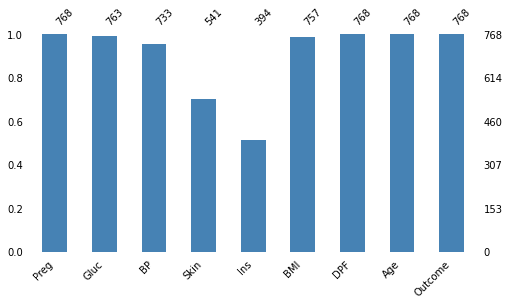

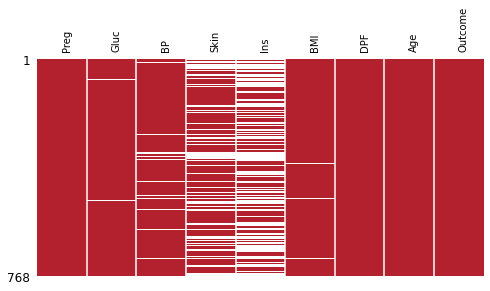

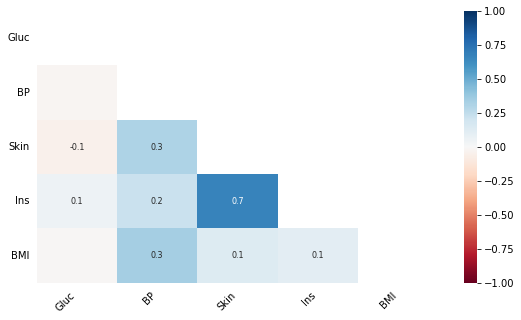

In [5]:
# visualise number of missing values

msno.bar(diabetesNaN, figsize = (8,4), fontsize = 10, color = 'steelblue')
plt.show()

msno.matrix(diabetesNaN, figsize = (8,4), label_rotation = 90, fontsize = 10, color = (0.70, 0.13, 0.18), sparkline = False)
plt.show()

msno.heatmap(diabetesNaN, figsize = (9,5), fontsize = 10)
plt.show()

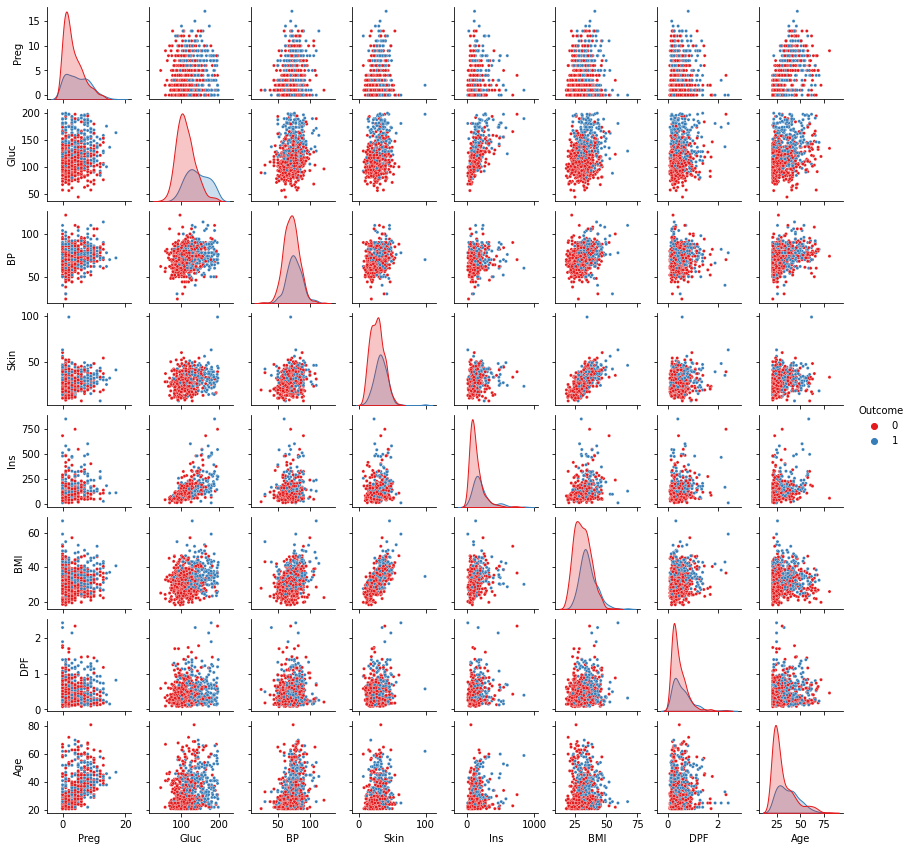

In [6]:
sns.pairplot(diabetes, height = 1.5, hue = 'Outcome', palette = 'Set1', plot_kws = {"s": 10})
plt.show()

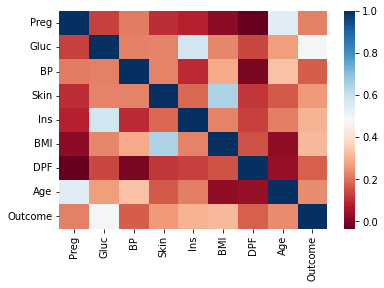

In [7]:
# visualise correlation between features
sns.heatmap(diabetes.corr(), cmap = "RdBu")
plt.show()

In [8]:
# split the data into training and testing sets
trainNaN, testNaN = train_test_split(diabetesNaN, train_size = 0.70, stratify = diabetesNaN['Outcome'], random_state = 42)

# split training and testing sets into features (x) and class (y) for each
trainNaN_x = (trainNaN[trainNaN.columns[:-1]])
train_y = (trainNaN[trainNaN.columns[-1]])

testNaN_x = (testNaN[testNaN.columns[:-1]])
test_y = (testNaN[testNaN.columns[-1]])

In [9]:
def choose_k(name, model, train_x, train_y):
    means = []
    kValues = [1,3,5,7,9,11,13,15,17,19,21]
    for k in kValues:
        # create a pipeline to run the imputer with each model
        pipeline = Pipeline(steps = [('i', KNNImputer(n_neighbors = k)), ('m', model)])
        
        # run the model with 10 fold cross validation to determine accuracy
        accuracy = cross_val_score(pipeline, train_x, train_y, cv = 10)
        means.append(np.mean(accuracy))

    # pick the maximum mean in list and save index
    index = np.argmax(means)

    # access the index of the highest mean score
    max_k = kValues[index]
    print('Best k-value to use for', name, 'is', max_k)
    return max_k

In [10]:
# run each model to determine best k to use in the KNNImputer
NB_k = choose_k('Naive Bayes', GaussianNB(), trainNaN_x, train_y)
RF_k = choose_k('Random Forest', RandomForestClassifier(), trainNaN_x, train_y)
SVM_k = choose_k('SVM', SVC(), trainNaN_x, train_y)

Best k-value to use for Naive Bayes is 5
Best k-value to use for Random Forest is 5
Best k-value to use for SVM is 7


In [11]:
# Print values before imputation
print('\nBefore imputation')
print(trainNaN_x[['BP', 'Skin', 'Ins']].describe())

# new data frame with selected features for graphing
describeOrig = pd.DataFrame(trainNaN_x)[['BP', 'Skin', 'Ins']]

# create a new 'Imputation' column for the boxplot, and set every value to 'Before'
describeOrig['Imputation'] = 'Before'

# use imputer with chosen k-value to fill in missing data
KNN_imputer = KNNImputer(n_neighbors = 5)
trainImpute_x = KNN_imputer.fit_transform(trainNaN_x)
testImpute_x = KNN_imputer.fit_transform(testNaN_x)

# Print values after imputation
print('\nAfter imputation')
print(pd.DataFrame(trainImpute_x, columns = trainNaN_x.columns)[['BP', 'Skin', 'Ins']].describe())

# new data frame with selected features for graphing
describeNew = pd.DataFrame(trainImpute_x, columns = trainNaN_x.columns)[['BP', 'Skin', 'Ins']]

# create a new 'Imputation' column for the boxplot, and set every value to 'After'
describeNew['Imputation'] = 'After'



Before imputation
               BP        Skin         Ins
count  514.000000  380.000000  281.000000
mean    72.237354   28.839474  149.953737
std     12.456790    9.821522  108.950487
min     24.000000    7.000000   16.000000
25%     64.000000   22.000000   76.000000
50%     72.000000   29.000000  126.000000
75%     80.000000   36.000000  182.000000
max    122.000000   60.000000  744.000000

After imputation
               BP        Skin         Ins
count  537.000000  537.000000  537.000000
mean    72.301304   28.900186  145.185102
std     12.281761    8.778554   88.682856
min     24.000000    7.000000   16.000000
25%     64.000000   23.000000   85.200000
50%     72.000000   29.000000  131.600000
75%     80.000000   34.000000  180.000000
max    122.000000   60.000000  744.000000


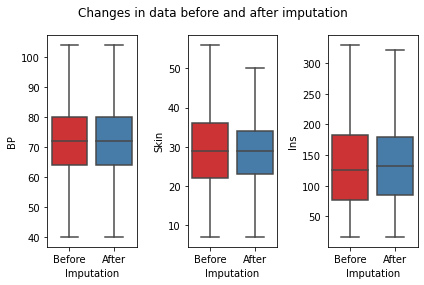

In [12]:
# create boxplot to highlight only small changes in values
fig, axes = plt.subplots(1, 3)
plot = pd.concat([describeOrig, describeNew])
sns.boxplot(data = plot, y ='BP', x = 'Imputation', palette = 'Set1', showfliers = False, ax = axes[0])
sns.boxplot(data = plot, y ='Skin', x = 'Imputation', palette = 'Set1', showfliers = False, ax = axes[1])
sns.boxplot(data = plot, y ='Ins', x = 'Imputation', palette = 'Set1', showfliers = False, ax = axes[2])
fig.suptitle('Changes in data before and after imputation')
plt.tight_layout()
plt.show()

In [13]:
def tuneHyperparam(name, classifier, params, train_x, train_y, test_x):
    # perform testing of all parameters specified in grid
    model = GridSearchCV(classifier, params, n_jobs = -1)

    # input model with best parameters into training
    model, prediction = trainModel(model, train_x, train_y, test_x)

    # print best parameters after tuning
    print('Best parameters for', name, model.best_params_)
    return model, prediction

In [14]:
def trainModel(model, train_x, train_y, test_x):
    model.fit(train_x, train_y)
    prediction = model.predict(test_x)
    return model, prediction

In [15]:
# create dictionaries of all hyperparameters to be tested for each classifier
paramsRF = [
{'n_estimators': [100, 200, 500, 800, 1000] , 'max_depth': [None, 3, 5, 10, 15], 
'max_features': ['auto','sqrt', 'log2'], 'min_samples_leaf': [1, 2, 4, 6 ,8], 'min_samples_split': [2, 5, 10, 14]}]

paramsSVM = [
{'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}]


# call functions for tuning hyperparameters for Random Forest and SVC and train all classifiers
modelNB, predictionNB = trainModel(GaussianNB(), trainImpute_x, train_y, testImpute_x)
modelRF, predictionRF = tuneHyperparam('RF', RandomForestClassifier(), paramsRF, trainImpute_x, train_y, testImpute_x)
modelSVM, predictionSVM = tuneHyperparam('SVM', SVC(probability = True), paramsSVM, trainImpute_x, train_y, testImpute_x)


Best parameters for RF {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 100}
Best parameters for SVM {'C': 1, 'kernel': 'linear'}


In [16]:
def createConfMatrix(predictions, graphTitle):
    # produce confusion matrix from test classes and predicted classes
    confMatrix = metrics.confusion_matrix(test_y, predictions)

    # show confusion matrix with metrics labels
    metricsLabel = ['True Neg','False Pos','False Neg','True Pos']

    # get counts from confusion matrix to use as labels and format for legibility
    metricsCounts = ['{0:0.0f}'.format(value) for value in confMatrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(metricsLabel, metricsCounts)]
    labels = np.asarray(labels).reshape(2,2)

    # show confusion matrix
    ax = sns.heatmap(confMatrix, annot = labels, cbar = False, fmt = '', cmap = 'Blues')
    ax.set(title = graphTitle)
    plt.show()

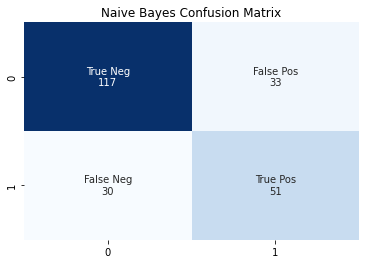

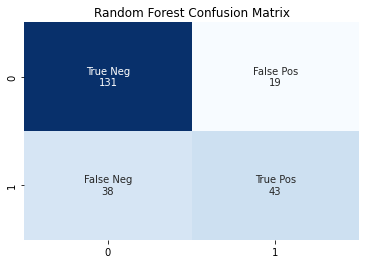

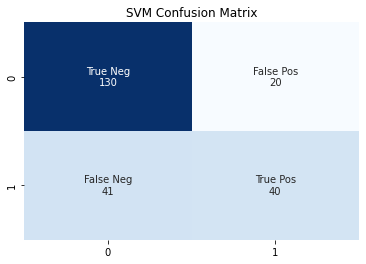

In [17]:
# call function to create confusion matrices for each model
createConfMatrix(predictionNB,'Naive Bayes Confusion Matrix')
createConfMatrix(predictionRF, 'Random Forest Confusion Matrix')
createConfMatrix(predictionSVM, 'SVM Confusion Matrix')

In [18]:
def calculateMetrics(name, test_x, test_y, model):
    # define metrics to be used
    scoringMetrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    scores = cross_validate(model, test_x, test_y, scoring = scoringMetrics, cv = 10)

    # calculate each metric
    meanAcc = np.mean(scores['test_accuracy'])
    meanPrec = np.mean(scores['test_precision_macro'])
    meanRec = np.mean(scores['test_recall_macro'])
    meanF1 = np.mean(scores['test_f1_macro'])

    # print reults, each to 3 decimal places
    print(name, 'accuracy: %.3f' % meanAcc)
    print(name, 'precision: %.3f' % meanPrec)
    print(name, 'recall: %.3f' % meanRec)
    print(name, 'F1 score: %.3f' % meanF1)

    return meanAcc, meanPrec, meanRec, meanF1

In [19]:
# calculate the metrics for each trained model and test data
calculateMetrics('Naive Bayes', testImpute_x, test_y, modelNB)
calculateMetrics('Random Forest', testImpute_x, test_y, modelRF)
calculateMetrics('SVM', testImpute_x, test_y, modelSVM)

Naive Bayes accuracy: 0.732
Naive Bayes precision: 0.712
Naive Bayes recall: 0.702
Naive Bayes F1 score: 0.699
Random Forest accuracy: 0.745
Random Forest precision: 0.745
Random Forest recall: 0.706
Random Forest F1 score: 0.698
SVM accuracy: 0.705
SVM precision: 0.687
SVM recall: 0.676
SVM F1 score: 0.675


(0.7052536231884057, 0.6872911361514303, 0.67625, 0.6748520590068152)

Naive Bayes AUC: 0.819
Random Forest AUC: 0.826
SVM AUC: 0.835


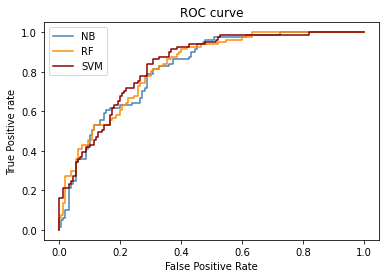

In [30]:
# predict probabilities
probNB = modelNB.predict_proba(testImpute_x)
probRF = modelRF.predict_proba(testImpute_x)
probSVM = modelSVM.predict_proba(testImpute_x)

# create rates and thresholds for ROC curve
falsePosRateNB, truePosRateNB, thresholdNB = metrics.roc_curve(test_y, probNB[:,1], pos_label = 1)
falsePosRateRF, truePosRateRF, thresholdRF = metrics.roc_curve(test_y, probRF[:,1], pos_label = 1)
falsePosRateSVM, truePosRateSVM, thresholdSVM = metrics.roc_curve(test_y, probSVM[:,1], pos_label = 1)

# calculate and print AUC value for comparison
print('Naive Bayes AUC: %.3f' % metrics.auc(falsePosRateNB, truePosRateNB))
print('Random Forest AUC: %.3f' % metrics.auc(falsePosRateRF, truePosRateRF))
print('SVM AUC: %.3f' % metrics.auc(falsePosRateSVM, truePosRateSVM))


# plot ROC curve for each classifier
plt.plot(falsePosRateNB, truePosRateNB, label = 'NB', color = 'steelblue')
plt.plot(falsePosRateRF, truePosRateRF, label='RF', color = 'darkorange')
plt.plot(falsePosRateSVM, truePosRateSVM, label='SVM', color = 'DarkRed')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc = 'best')
plt.show()